In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
import importlib
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

# 상위 폴더에서 module을 import하기 위해 시스템 경로에 상위 폴더의 경로를 추가
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

In [2]:
### morning data
with open('../data/preprocess/e_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

#print(data_list[1].shape)
data_list = append_cycle_size(data_list)
#print(data_list[1].shape)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [3]:
# load model
model = LSTMModel_cycle(input_size = 12, hidden_size = 32, no_time_size = 4).to(device)
# set model

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
num_epochs  = 300
hist = np.zeros(num_epochs)

train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,1]) ### trend
    train_error.append(loss)

    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,1]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, 'models/best_cycles.pkl')

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()
    
    
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
best_model = torch.load('models/best_cycles.pkl')


10 Epochs train MSE: 0.02516 // valid MSE: 0.02752
20 Epochs train MSE: 0.02348 // valid MSE: 0.02650
30 Epochs train MSE: 0.01568 // valid MSE: 0.02298
40 Epochs train MSE: 0.01040 // valid MSE: 0.02152
50 Epochs train MSE: 0.00778 // valid MSE: 0.02091
60 Epochs train MSE: 0.00614 // valid MSE: 0.02029
70 Epochs train MSE: 0.00524 // valid MSE: 0.02072
80 Epochs train MSE: 0.00471 // valid MSE: 0.02174
90 Epochs train MSE: 0.00425 // valid MSE: 0.02202
100 Epochs train MSE: 0.00386 // valid MSE: 0.02315
110 Epochs train MSE: 0.00352 // valid MSE: 0.02408
120 Epochs train MSE: 0.00324 // valid MSE: 0.02366
130 Epochs train MSE: 0.00295 // valid MSE: 0.02410
140 Epochs train MSE: 0.00275 // valid MSE: 0.02462
150 Epochs train MSE: 0.00257 // valid MSE: 0.02449
160 Epochs train MSE: 0.00236 // valid MSE: 0.02535
170 Epochs train MSE: 0.00223 // valid MSE: 0.02599
180 Epochs train MSE: 0.00220 // valid MSE: 0.02701
190 Epochs train MSE: 0.00205 // valid MSE: 0.02756
200 Epochs train MSE:

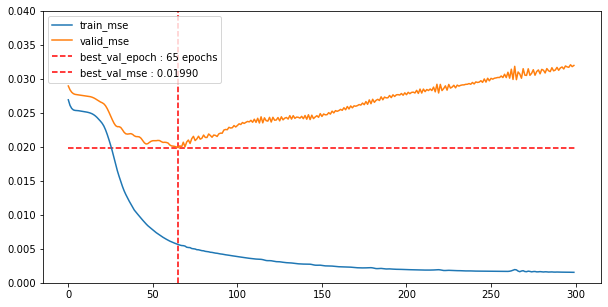

In [5]:
plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = num_epochs,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.04)
plt.show()

In [6]:
print("evenving cycle results")

train_pred = best_model(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,1]))

valid_pred = best_model(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,1]))

test_pred = best_model(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,1]))

evenving cycle results
train_error :  tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward>)
test_error :  tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>)


In [7]:
# trend
i = 1
print("morning trend")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

morning trend
zeros error :  0.025200266
random normal error :  1.0291276


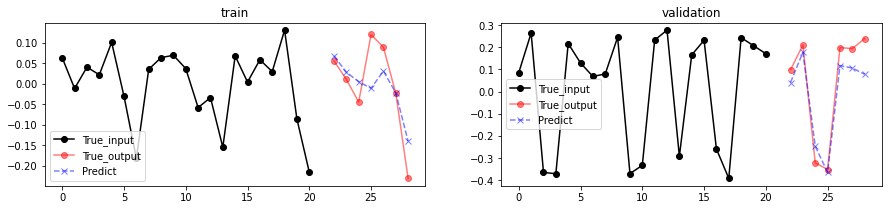

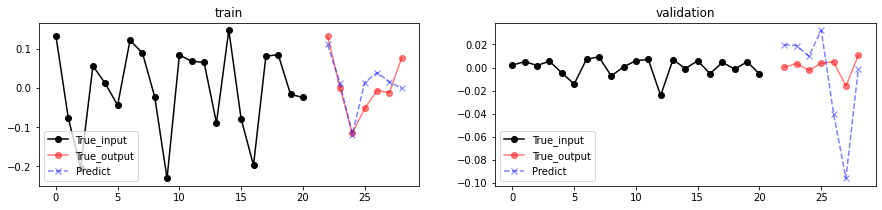

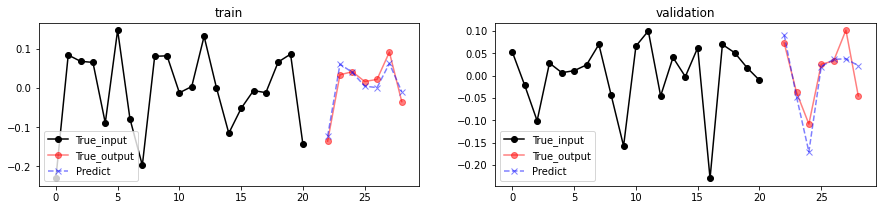

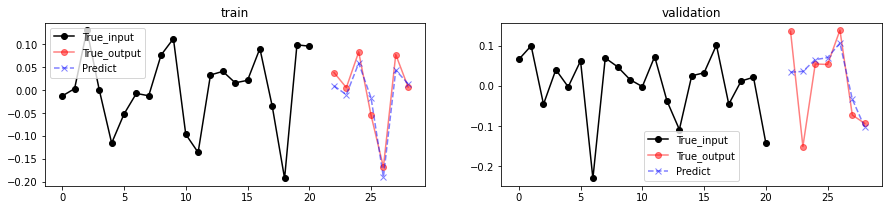

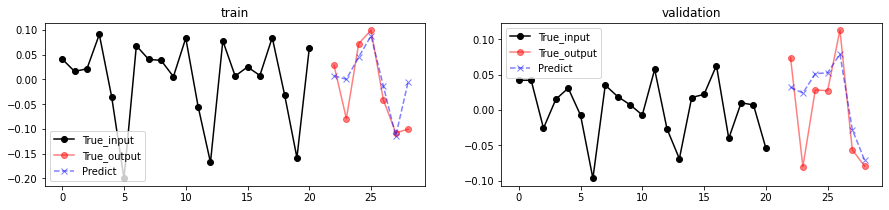

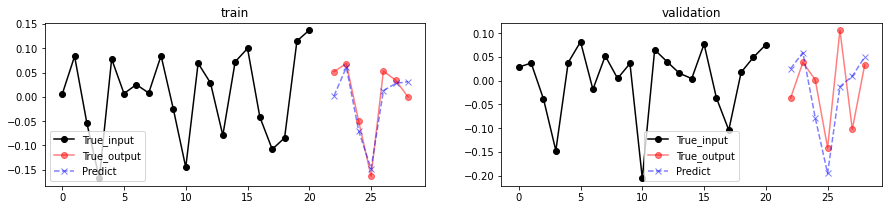

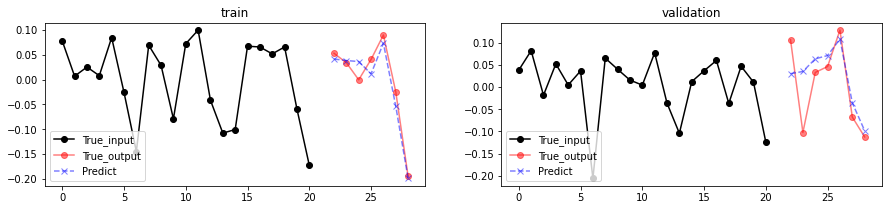

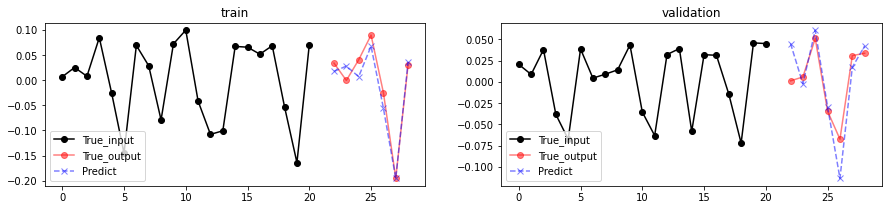

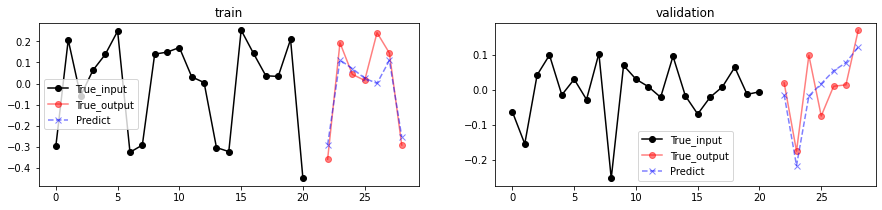

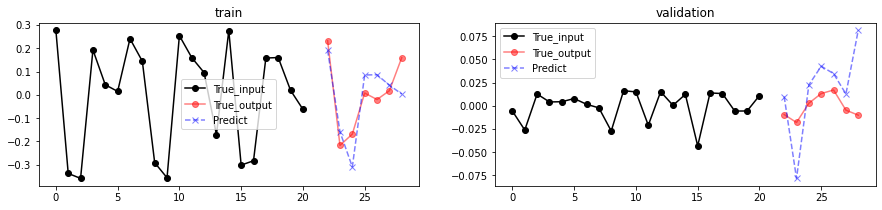

In [8]:
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])
# plot result
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    valid_time_x_np, valid_y_np, valid_pred_np]
### morning result
path = '../data/train_results/evening_results/'
with open(path + 'e_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)

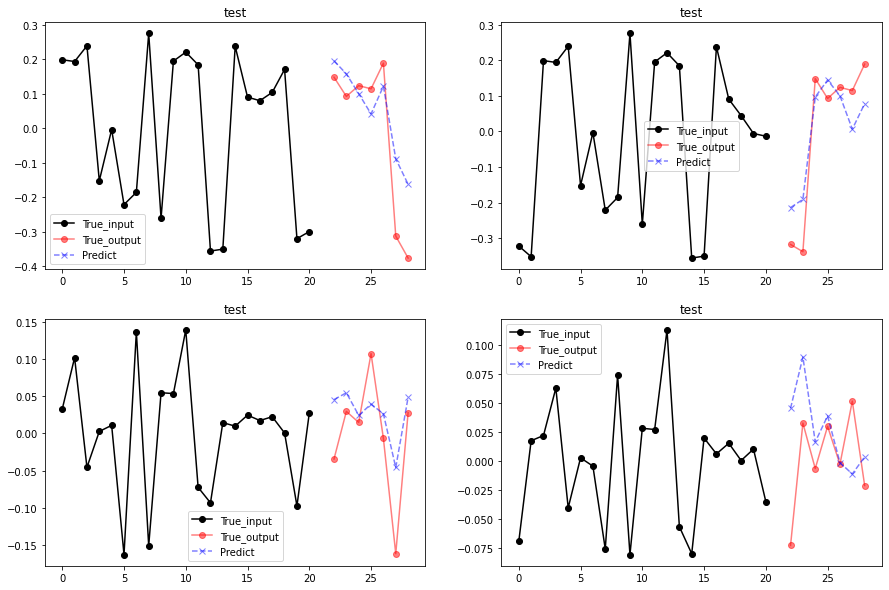

In [28]:
train_pred = best_model(train_time, train_notime)
test_pred = best_model(test_time, test_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        test_time[:,:,-1], test_y[:,:,1], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    test_time_x_np, test_y_np, test_pred_np]

In [9]:
with open('../data/preprocess/june_data/evening_june_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/preprocess/june_data/evening_june_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

tc = 1
cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
pred_y = best_model(train_time_x, train_notime_x)
pred_y = np.array(pred_y.cpu().detach())

path = '../data/preprocess/'
with open(path + 'june_evening_cycle_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)